In [36]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler,Estimator
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient,ParamShiftSamplerGradient
from qiskit.circuit import ParameterVector
%matplotlib inline


In [37]:
from VQS_header import compute_params_list,compute_magnetization

In [57]:
num_qubits = 2
j_coupling = 1/4
h_coupling = 1

num_layers = 3
time_max = 5e0
epsilon_det = 1e-7
num_steps = 100
sampler = Sampler()
estimator = Estimator()
nShots=None

dt=time_max/num_steps
sampler=Sampler()

print("dt = ",dt)

dt =  0.05


In [58]:
def addSuzukiTrotter(circuit,j,h,dt):
    num_qubits=circuit.num_qubits
    #Implementing Suzuki-Trotter evolution step for the transverse Ising
    for i in range(num_qubits):
        circuit.rx(-2*h*dt,i)
    
    for i in range(num_qubits-1):
        circuit.rzz(-2*j*dt,i,i+1)
    return circuit

def getAnsatz(num_qubits,n_layers=3,weight_name="weight"):
    n_params=n_layers*(2*num_qubits-1)
    ansatz = QuantumCircuit(num_qubits,num_qubits) 
    weights = ParameterVector(weight_name, n_params)
    params_index=0
    for layer in range(num_layers):
        for i in range(num_qubits):
            ansatz.rx(weights[params_index],i)
            params_index+=1
        for i in range(num_qubits-1):
            ansatz.rzz(weights[params_index],i,i+1)
            params_index+=1
            
    return ansatz
    

def getCircuit(num_qubits,n_layers=3,j=j_coupling,h=h_coupling,dt=dt):
    circuit = QuantumCircuit(num_qubits,num_qubits) 
    
    ansatz = getAnsatz(num_qubits,n_layers=n_layers)
    ansatz_inv = getAnsatz(num_qubits,n_layers=n_layers,weight_name="weight_inverse").inverse()
    #circuit.h(circuit.qubits)
    circuit.compose(ansatz_inv, inplace=True)
    addSuzukiTrotter(circuit,j,h,dt)
    circuit.compose(ansatz, inplace=True)  
    
    circuit.measure(circuit.qubits,circuit.clbits)
    return circuit

In [59]:
qc = getCircuit(num_qubits,n_layers=num_layers)

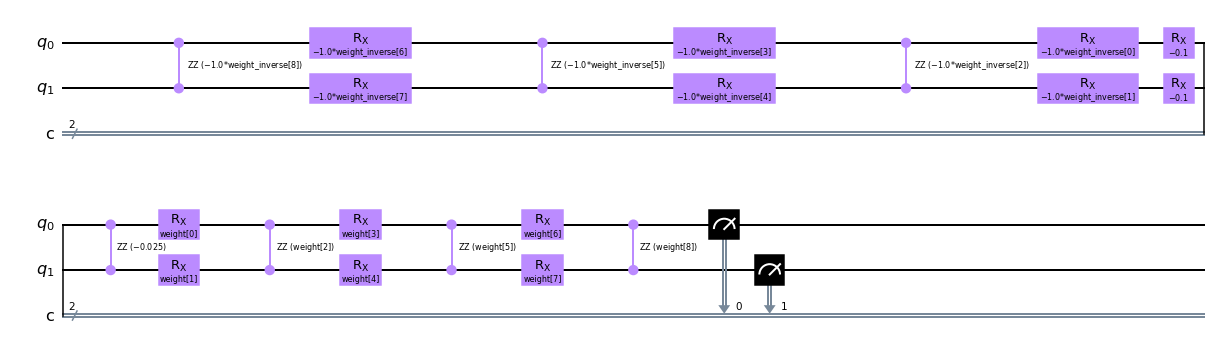

In [60]:
qc.draw('mpl')

In [65]:
print("dt = ",dt)
n_params_ansatz=int(qc.num_parameters/2)
weights_init=np.random.rand(n_params_ansatz)
weights_init=np.concatenate([weights_init,weights_init])
weights=weights_init
learning_rate=1e-1

for step in range(50):
    weights_list=[weights]
    for i in range(n_params_ansatz):
        weightsPlus=weights.copy()
        weightsPlus[i]+=np.pi/2
        weights_list.append(weightsPlus)

        weightsMinus=weights.copy()
        weightsMinus[i]-=np.pi/2
        weights_list.append(weightsMinus)

    results=sampler.run(circuits=[qc]*len(weights_list),parameter_values=weights_list).result().quasi_dists
    output=results[0][0]
    #loss=(1-(output)**2)/(dt**2)
    loss=(1-output)**2

    grad_list=[]
    for i in range(n_params_ansatz):

        tmpGrad_output=0.5*(results[2*i+1][0] - results[2*i+2][0])
        #tmpGrad = ((-2*output)/(dt**2))*tmpGrad_output
        tmpGrad = ((-2*output))*tmpGrad_output
        #tmpGrad = tmpGrad_output*(-1)
        grad_list.append(tmpGrad)
        
    grad_list=np.array(grad_list)
    weights[0:n_params_ansatz]-=learning_rate*grad_list
    print(tmpGrad_output)
    print(output,loss)
    print('----')

dt =  0.05
0.0
0.9954327245794888 2.0860004766805423e-05
----
0.0
0.9975234548629752 6.133275815721072e-06
----
0.0
0.9986514139863142 1.8186842363089979e-06
----
0.0
0.9992577118140132 5.509917510555169e-07
----
0.0
0.9995833950398568 1.7355969281589583e-07
----
0.0
0.9997586443953568 5.825252789269578e-08
----
0.0
0.9998533349592647 2.151063417390182e-08
----
0.0
0.9999048597014556 9.051676407118508e-09
----
0.0
0.9999332059625968 4.461443432616447e-09
----
0.0
0.9999490584227992 2.595044287700808e-09
----
0.0
0.9999581354124268 1.7526436926707294e-09
----
0.0
0.9999635043581548 1.331931873690037e-09
----
0.0
0.9999668168741894 1.1011198385605392e-09
----
0.0
0.9999689673785626 9.630235932796749e-10
----
0.0
0.9999704443898144 8.735340934421476e-10
----
0.0
0.9999715180497768 8.112214885169875e-10
----
0.0
0.999972340365159 7.650553995358448e-10
----
0.0
0.9999729989142369 7.290586323887281e-10
----
0.0
0.9999735457221026 6.998288190718536e-10
----
0.0
0.9999740128670548 6.7533107871

In [56]:
len(weights_list)

19

In [10]:
n_params_ansatz

6

In [ ]:
gradSampler=ParamShiftSamplerGradient(sampler)

In [ ]:
# qc = getCircuit(num_qubits,n_reps=3,dt=0.05)
# learning_rate=1e1


# weights_init=np.random.rand(int(qc.num_parameters/2))
# weights_last=weights_init.copy() # important to keep it as a copy
# weights_tmp=weights_init.copy()
# weights_all=np.concatenate([weights_tmp,weights_last])

# print(weights_all)

In [ ]:

# for step in range(2):

#     output=sampler.run(circuits=[qc],parameter_values=[weights_all]).result().quasi_dists[0][0]
#     loss=((1-output)**2)/dt
    
#     print("initial loss =",loss)

#     for i in range(100):
        
#         if loss<1e-5:
#             print("loss = ",loss, "number of iterations = ",i)
#             break
            
#         result=gradSampler.run(circuits=[qc],parameter_values=[weights_all],parameters=[qc.parameters[0:int(qc.num_parameters/2)]])
#         grad=result.result().gradients[0]
#         for j in range(len(weights_tmp)):
#             #weights_tmp[j]+=learning_rate*grad[j][0]
#             weights_tmp[j]-=2*((1-output)/dt)*(-1)*learning_rate*grad[j][0]
#         weights_all=np.concatenate([weights_tmp,weights_last])
        

#         output=sampler.run(circuits=[qc],parameter_values=[weights_all]).result().quasi_dists[0][0]
#         loss=((1-output)**2)/dt
#         print(loss)

#     print("loss = ",loss, "number of iterations = ",100)
            

    
#     weights_last=weights_tmp.copy()
#     weights_all=np.concatenate([weights_tmp,weights_last])
    
